#### The cell below imports necessary libraries and defines necessary functions

In [22]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import random
from pandas.tseries.offsets import MonthEnd
import scipy.stats as st
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

####Functions to assist with forecasting
def daily_ses_forecast (actuals, days):
    
    model = SimpleExpSmoothing(actuals).fit(#smoothing_level=0.1, 
                                            optimized = True)
    
    return model.forecast(days)

def daily_doubleES_forecast (actuals, days):
    
    model= ExponentialSmoothing(actuals,trend='mul').fit(smoothing_level = 0.05,
                                                         smoothing_trend = 0.25,
                                                         optimized = False)
    return model.forecast(days)

def daily_tripleES_forecast (actuals, days):
    
    model = ExponentialSmoothing(actuals,
                                 trend='mul',
                                 seasonal='mul',
                                 seasonal_periods=7).fit(smoothing_level = 0.05,
                                                         smoothing_trend = 0.7,
                                                         smoothing_seasonal = 0.4,
                                                         optimized = False)
    return model.forecast(days)

def monthly_ses_forecast (actuals, days):
    
    model = SimpleExpSmoothing(actuals).fit(smoothing_level=0.9, optimized = False)
    
    return model.forecast(days)

def monthly_doubleES_forecast (actuals, days):
    
    model= ExponentialSmoothing(actuals,trend='mul').fit(smoothing_level = 0.9,
                                                         smoothing_trend = 0.05,
                                                         optimized = False)
    return model.forecast(days)

def monthly_tripleES_forecast (actuals, days):
    
    model = ExponentialSmoothing(actuals,
                                 trend='mul',
                                 seasonal='mul',
                                 seasonal_periods=12).fit(smoothing_level = 0.6,
                                                         smoothing_trend = 0.7,
                                                         smoothing_seasonal = 0.3,
                                                         optimized = False)
    return model.forecast(days)


#Functions to assist with inventory simulation
def reorder_point (item, forecast_df, date, es = False):
     
    lead = lead_times[item]
    
    if es:
        reorder_point = forecast_df.loc[forecast_df['item']==item].loc[date][f"ROP Forecast {lead}"]
    else:
        reorder_point = forecast_df.loc[forecast_df['item']==item].loc[date]['ROP Forecast']
        reorder_point *= lead
    
    return reorder_point

def get_EOQ (item, forecast_df, date):

    #retreive current annual demand forecast
    annual_demand = forecast_df.loc[forecast_df['item'] == item].loc[date]['EOQ Forecast']
    
    #retreive order cost and holding cost
    order = order_cost[item]
    holding = holding_cost[item] * 365
     
    #calculate EOQ
    eoq = round((2 * order * annual_demand / holding) ** (1/2), 0)
    
    return eoq

def simluate_item (item, ROP_revaluation, EOQ_revaluation, sim_start_date, starting_stock,
                   lead_times, daily_sales, ROP_forecast, EOQ_forecast, es = False):
    
    #get item_sales_df
    item_sales = daily_sales.loc[item]
    
    #empty df to store the results of the simulation
    sim_df = pd.DataFrame()
    
    #set simulation end date
    sim_end = pd.to_datetime('2017-12-31')
    
#beginning data for sim:
    
    #get starting ROP, EOQ, lead time, and starting stock for the item 
    ROP = reorder_point(item, ROP_forecast, sim_start_date, es)
    EOQ = get_EOQ (item, EOQ_forecast, str(pd.to_datetime(sim_start_date) + MonthEnd(0))[:10])
    
    lead = lead_times[item]
    cur_stock = starting_stock

    #get starting dates, first revaluation dates, and the next pause date
    last_pause = pd.to_datetime(sim_start_date)
    
    ROP_eval = last_pause + timedelta(days = ROP_revaluation)
    EOQ_eval = last_pause + timedelta(days = EOQ_revaluation)
    
    next_pause = min(ROP_eval, EOQ_eval, sim_end)
    
    #set up order in transit variables
    order_in_transit = False
    order_arrive_date = None
    
#start simulation
    while last_pause != sim_end:

        #create lists for the data you want to gather
        stock = []
        order_placed = []
        in_transit = []
        reorder_points = []
        e_order_quantities = []

        #grab the dates that are currently being simulated
        str_last_pause = str(last_pause)[:10]
        str_next_pause = str(next_pause)[:10]
        sim = pd.DataFrame(item_sales.loc[str_last_pause:str_next_pause])

        #run the sim for the specified dates
        for s, d in zip(sim['sales'], sim.index):
            
            reorder_points.append(ROP)
            e_order_quantities.append(EOQ)

        #did an order arrive today? If so, adjust stock and reset order arrive date & order in transit
            if d == order_arrive_date:
                cur_stock += EOQ
                order_arrive_date = None
                order_in_transit = False

        #adjust stock for daily sales
            cur_stock -= s
            cur_stock = max(cur_stock, 0)

        #record ending stock
            stock.append(cur_stock)

        #evalute if an order needs to be placed:

            #check if an order is already in-transit:
            if order_in_transit == False:

                #if not, check if the re-order point has been hit:
                if cur_stock <= ROP:
                    
                    #if it has, 'place an order'
                    order_placed.append(1)
                    order_in_transit = True
                    order_arrive_date = d + timedelta(days = lead)

                #if ROP is not hit, don't place and order and continue with business
                else:
                    order_placed.append(0)

            #if there is an order in transit, don't place an order and continue with business
            else:
                order_placed.append(0)

            #at the end of the day, is there an order in transit? 
            in_transit.append(order_in_transit)

        #add data to the mini dataframe sim 
        sim['stock'] = stock
        sim['ROP'] = reorder_points
        sim['EOQ'] = e_order_quantities
        sim['order_placed'] = order_placed
        sim['order_in_transit'] = in_transit

        #store the data outside of the while loop in sim_df
        sim_df = pd.concat([sim_df, sim])

    #set up for next sim
       
        #did we stop the sim to revaluate ROP? 
        if next_pause == ROP_eval:
            
            #if so, set a new ROP
            ROP = reorder_point (item, ROP_forecast, str(ROP_eval)[:10], es)
            
            #if so, set a new ROP_eval date
            ROP_eval += timedelta(days = ROP_revaluation)
            ROP_eval = min(ROP_eval, sim_end)
            
        #did we stop the sim to revaluate EOQ? 
        else:
            
            f = str(EOQ_eval)[:10]
            
            #if so, set a new EOQ
            EOQ = get_EOQ (item, EOQ_forecast, str(pd.to_datetime(f) + MonthEnd(0))[:10])
                           
            #if so, set a new EOQ_eval date
            EOQ_eval += timedelta(days = EOQ_revaluation)
            EOQ_eval = min(EOQ_eval, sim_end)
        
        #change last pause to reflect the end date of this mini sim
        last_pause = next_pause
        
        #set the next pause date
        next_pause = min(ROP_eval, EOQ_eval, sim_end) 
    
    return sim_df

##Functions to help analyze the results of the simulation
def operating_results (sim_result, r, c, oc, hc):
    
    temp_df = sim_result.copy()
    
    temp_df['gross_margin'] = temp_df['sales']*r - temp_df['sales']*c
    
    temp_df['opportunity_cost'] = 0
    temp_df['opportunity_cost'] = np.where((temp_df['stock'] == 0), temp_df['gross_margin'], temp_df['opportunity_cost'])
    
    temp_df['gross_margin'] = np.where((temp_df['stock'] == 0), 0, temp_df['gross_margin'])
    
    temp_df['order_cost'] = temp_df['order_placed'] * oc
    
    temp_df['holding_cost'] = 0
    temp_df['holding_cost'] = np.where((temp_df['stock'] > 0), temp_df['stock'] * hc, temp_df['holding_cost'])
    
    temp_df['inventory_cost'] = temp_df['holding_cost'] + temp_df['order_cost']
    
    temp_df['operating_margin'] = temp_df['gross_margin'] - temp_df['inventory_cost']
    
    return temp_df

def evaluate (operating_results_es, operating_results_ma):
    
    a=operating_results_es[['gross_margin', 'operating_margin', 'opportunity_cost', 'inventory_cost', 'holding_cost', 'order_cost']]
    b=operating_results_ma[['gross_margin', 'operating_margin', 'opportunity_cost', 'inventory_cost', 'holding_cost', 'order_cost']]
    
    
    es_results = {'Operating Metric':['Gross Margin','Inventory Cost', 'Operating Margin','Opportunity Cost', 'Order Costs', 'Holding Costs'],
                  'Total':[a['gross_margin'].sum(),a['inventory_cost'].sum(),a['operating_margin'].sum(),a['opportunity_cost'].sum(),
                           a['order_cost'].sum(), a['holding_cost'].sum()]}
    
    ma_results = {'Operating Metric':['Gross Margin','Inventory Cost', 'Operating Margin','Opportunity Cost', 'Order Costs', 'Holding Costs'],
                  'Total':[b['gross_margin'].sum(),b['inventory_cost'].sum(),b['operating_margin'].sum(),b['opportunity_cost'].sum(),
                           b['order_cost'].sum(), b['holding_cost'].sum()]}
    
    es_results = pd.DataFrame(es_results)
    ma_results = pd.DataFrame(ma_results)
    
    pd.concat({'Exponential Smoothing': es_results.set_index('Operating Metric'),
               'Moving Averages': ma_results.set_index('Operating Metric')}, axis=1).plot.bar(title = 'Comparative Operating Results')
    
    return

# Incorporating Exponential Smoothing Into an Inventory Management Strategy

### Project Purpose: 
<b>The purpose of this notebook is to analyze the effectiveness of exponential smoothing as a demand forecasting methodology in improving the operational results of a system of inventory management.</b>


### Project Description:

Before proceeding, it's important to frame the system of inventory management used in this notebook. The system has two goals:
1. Minimize inventory costs (holding & ordering costs)
1. Minimize instances of stockouts
<br>

The system has two main components:
<br>
1. <b>Reorder Point:</b> This is the stock level at which more inventory should be ordered. Ideally, this should be set to help minimize inventory levels (reducing costs) while also preventing stockouts.  
<br>
<br>
2. <b>Order Quantity:</b> This is the quantity of stock that should be ordered at the reorder point. Ideally, the order quantity should minimize total inventory costs by balancing the relationship between an item's holding cost and ordering cost.

<br>
Both the reorder point and the order quantity can be calculated using a standardized methodology. The simulation in this workbook uses the Economic Order Quantity framework to calculate order quantity, and the reorder point is calculated by forecasting demand over the product's lead time. 
<br>
<br>
The crux of this analysis is that both calculations are reliant on a methodology to forecast demand. <b>The purpose of this notebook is to analyze the effectiveness of exponential smoothing as a demand forecasting methodology to improve operational results in this system of inventory management.</b>

## Step 1: Importing/Cleaning the Data

The data for this analysis is daily sales data for 50 items across 10 locations from 1/1/2013 to 12/31/2017. To appropriately limit scope, this analysis will focus on one item at a time, and assumes a centralized distribution system (i.e., demand across all 10 locations is evaluated in aggregate). 
<br>

The cell below imports the data and provides some initial formatting.

In [23]:
####Read the csv into a dataframe
df = pd.read_csv(r'/Users/painelewis/Desktop/demand.csv')
df['date'] = pd.to_datetime(df['date'])

#define function to format df
group = lambda x, t : x.groupby(by = ['item']).resample(rule=t, on='date').sum()

#format a sales by month and sales by day dataframe, plus some formatting
daily_sales = group(df, 'D')
daily_sales = daily_sales.drop(columns = ['store', 'item'])
monthly_sales = group(df, 'M')
monthly_sales = monthly_sales.drop(columns = ['store', 'item'])

#display the daily sales dataframe as an example
display(daily_sales.head())

sales
item date             
1    2013-01-01    133
     2013-01-02     99
     2013-01-03    127
     2013-01-04    145
     2013-01-05    149

The output is a dataframe for both monthly and daily sales grouped by item and ordered by date. Above is a sample of the daily sales dataframe.

The code below verifies that the data is 'clean' and that there are no missing values in either dataframe.

In [24]:
print(daily_sales.isnull().values.any())
print(monthly_sales.isnull().values.any())

False
False


## Step 2: Developing Forecasts

To determine whether exponential smooting <i> improves </i> an inventory management strategy, it is important to establish a baseline. For this analysis, the baseline will be representing my moving average forecasting. The same inventory management strategy will be simulated using weighted average forecasting and exponential smoothing forecasting, and the operational results will be evaluated. 

### Step 2a: Gathering moving average forecasts for the baseline

The code below populates two data frames (daily_sales_averages and monthly_sales_averages) with moving averages for each product as of each date (at daily and monthly intervals). A simple moving average and two different weighted moving averages are calculated.

In [4]:
#gather moving average information on a monthly/daily basis for items 1-10

#create dataframes for averages
daily_sales_averages = pd.DataFrame()
monthly_sales_averages = pd.DataFrame()

for item in range(1,51):
    
    #individual dfs for each item
    daily = daily_sales.loc[item]
    monthly = monthly_sales.loc[item]
    
    #label the df with the respective item no.
    daily['item'] = item
    monthly['item'] = item
    
    #previous 6 points daily (for moving-average forecasting)
    a = daily['sales'].shift(1)
    b = daily['sales'].shift(2)
    c = daily['sales'].shift(3)
    d = daily['sales'].shift(4)
    e = daily['sales'].shift(5)
    f = daily['sales'].shift(6)

    #simple moving average
    daily['daily_SMA'] = round((a + b + c + d + e + f)/6,0)
    
    #weighted moving averages
    daily['daily_WMA(1)'] = round(.5*a + .3*d + .2*c, 0)
    daily['daily_WMA(2)'] = round(.3*a + .25*b + .2*c + .1*d + .1*e + .05*f, 0)
    
    #previous 6 points monthly (for moving-average forecasting)
    a = monthly['sales'].shift(1)
    b = monthly['sales'].shift(2)
    c = monthly['sales'].shift(3)
    d = monthly['sales'].shift(4)
    e = monthly['sales'].shift(5)
    f = monthly['sales'].shift(6)
    
    #simple moving average
    monthly['monthly_SMA'] = round((a + b + c + d + e + f)/6,0)
    
    #weighted moving averages
    monthly['monthly_WMA(1)'] = round(.5*a + .3*d + .2*c, 0)
    monthly['monthly_WMA(2)'] = round(.3*a + .25*b + .2*c + .1*d + .1*e + .05*f, 0)

    daily_sales_averages = pd.concat([daily_sales_averages, daily])
    monthly_sales_averages = pd.concat([monthly_sales_averages, monthly])
    
#fill nas
daily_sales_averages = daily_sales_averages.fillna(method = 'bfill')
daily_sales_averages['ROP Forecast'] = daily_sales_averages['daily_WMA(2)']
monthly_sales_averages = monthly_sales_averages.fillna(method = 'bfill')
monthly_sales_averages['EOQ Forecast'] = monthly_sales_averages['monthly_WMA(2)'] * 12

display(daily_sales_averages.head(20))


,sales,item,daily_SMA,daily_WMA(1),daily_WMA(2),ROP Forecast
date,,,,,,
2013-01-01,133,1,134.0,132.0,140.0,140.0
2013-01-02,99,1,134.0,132.0,140.0,140.0
2013-01-03,127,1,134.0,132.0,140.0,140.0
2013-01-04,145,1,134.0,132.0,140.0,140.0
2013-01-05,149,1,134.0,132.0,140.0,140.0
2013-01-06,149,1,134.0,130.0,140.0,140.0
2013-01-07,92,1,134.0,142.0,140.0,140.0
2013-01-08,119,1,127.0,119.0,127.0,127.0
2013-01-09,114,1,130.0,134.0,124.0,124.0


Above is a sample of the daily_sales_averages dataframe (nan values were backfilled). 

### Step 2b: Refining exponential smoothing forecasts

The cells below utilize functions defined above to train exponential smoothing models using the SimpleExpSmoothing and ExponentialSmoothing libraries. Parameters for the models are set above within the defined functions. 

Running the cells will display the 6-month forcast as of 1/1/2014 for the final version of the single, double, and triple exponential smoothing models. The models below were trained to fit the sales distribution of item no. 1 from the imported dataset.

<Axes: title={'center': '6-month Daily Sales Forecast: Single Exponential Smoothing'}>

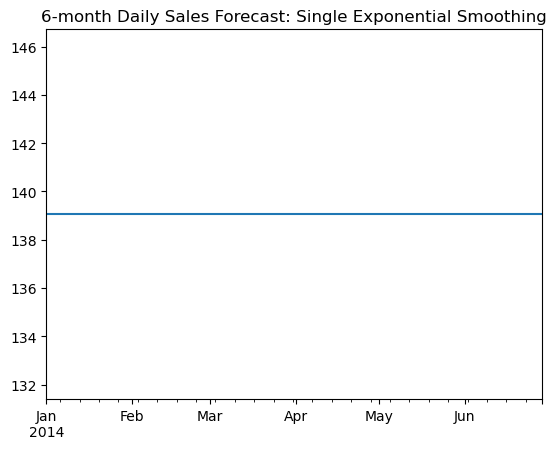

In [5]:
actuals = daily_sales.loc[1].loc['2013-01-01':'2013-12-31']

fc_df = pd.DataFrame()

fc_df['Single'] = daily_ses_forecast(actuals, 180)
fc_df['Double'] = daily_doubleES_forecast(actuals, 180)
fc_df['Triple'] = daily_tripleES_forecast(actuals, 180)
fc_df['Actuals'] = daily_sales.loc[1].loc['2014-01-01':'2014-06-30']

fc_df['Single'].plot(title = '6-month Daily Sales Forecast: Single Exponential Smoothing')

<Axes: title={'center': '6-month Daily Sales Forecast: Double Exponential Smoothing'}>

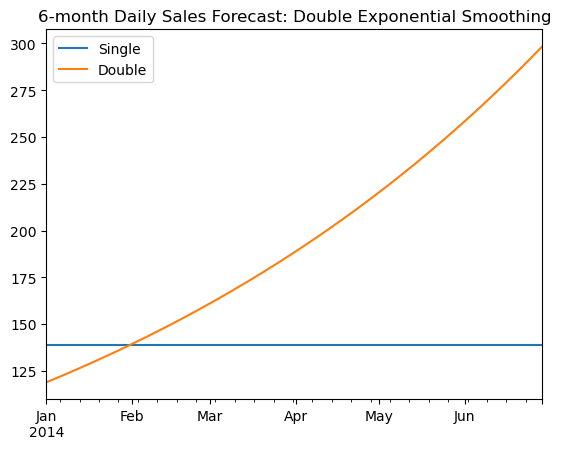

In [6]:
fc_df[['Single','Double']].plot(title = '6-month Daily Sales Forecast: Double Exponential Smoothing')

<Axes: title={'center': '6-month Daily Sales Forecast: Triple Exponential Smoothing'}>

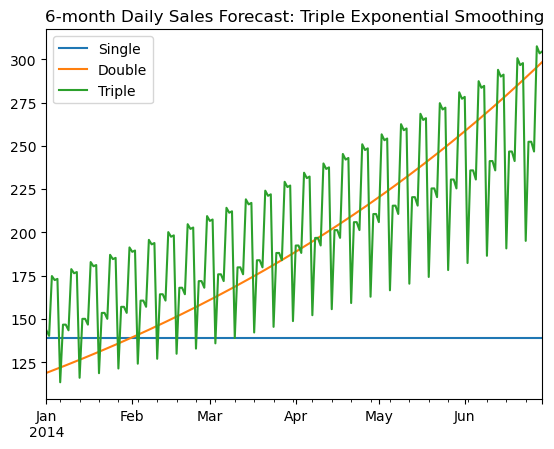

In [7]:
fc_df[['Single','Double', 'Triple']].plot(title = '6-month Daily Sales Forecast: Triple Exponential Smoothing')

The cell below shows actuals plotted over the forecasts displayed above.

<Axes: title={'center': '6-month Forecasts vs. Actuals'}>

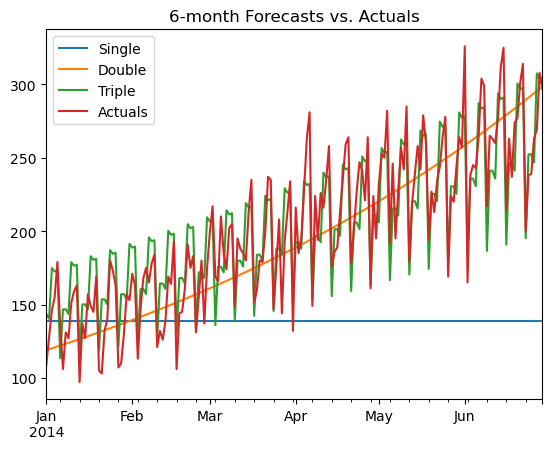

In [8]:
fc_df[['Single','Double', 'Triple', 'Actuals']].plot(title = '6-month Forecasts vs. Actuals')

The cell below shows the 12-month forecast of <b> monthly </b> sales as of 1/1/2015.

<Axes: title={'center': '12-month Monthly Sales Forecasts vs. Actuals'}>

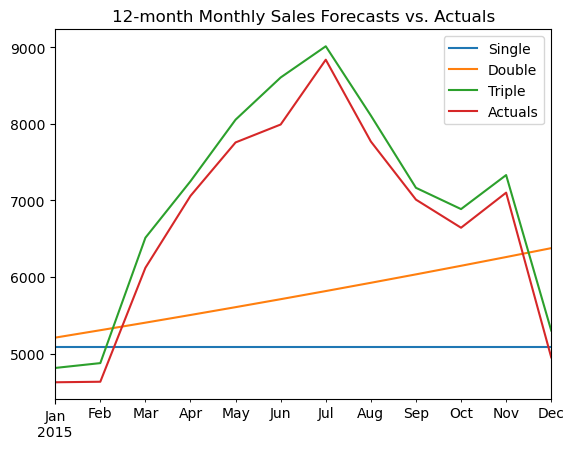

In [9]:
actuals = monthly_sales.loc[1].loc['2013-01-01':'2014-12-31']

mfc_df = pd.DataFrame()

mfc_df['Single'] = monthly_ses_forecast(actuals, 12)
mfc_df['Double'] = monthly_doubleES_forecast(actuals, 12)
mfc_df['Triple'] = monthly_tripleES_forecast(actuals, 12)
mfc_df['Actuals'] = monthly_sales.loc[1].loc['2015-01-01':'2016-02-01']

mfc_df.plot(title = '12-month Monthly Sales Forecasts vs. Actuals')

## Step 3: Run the Inventory Simulation

The steps below will walk you through the simulation process.

### Step 3a: Select an item to simulate

Enter any item no. from 1-50 below. This will be the item that is used for the simulation.

In [10]:
sim_item = 1

#### RUNNING THIS NEXT CELL TAKES APPROXIMATELY 30 SECONDS

#### Create Daily Exponential Smoothing Forecasts for the selected item

The simulation is designed to run for three years (from 1/1/2015 to 12/31/2017). The code cell below will forecast daily sales using triple exponential smoothing model developed above for each date that the simulation will run. Each forecast will be informed by all data available through the date of the forecast. This information is stored in the dataframe 'daily_es' for use in the simulation. 

In [11]:
#Add daily exponential smoothing forecast to es_df (approximately 30-sec runtime)
daily_es = pd.DataFrame()
for item in [sim_item]:
    df = daily_sales.loc[item]
    sim_df = pd.DataFrame(df.loc['2015-01-01':])
    for days in [7, 15, 30]:
        tes = []
        for date in sim_df.index:
            actuals = df.loc[:date]['sales']
            tes.append(daily_tripleES_forecast(actuals, days).sum())
        sim_df[f"{days}_day_TES"] = tes
    sim_df['item'] = item
    daily_es = pd.concat([daily_es, sim_df]) 

daily_es['ROP Forecast 7'] = daily_es['7_day_TES']
daily_es['ROP Forecast 15'] = daily_es['15_day_TES']
daily_es['ROP Forecast 30'] = daily_es['30_day_TES']    
    
print('DONE')

DONE


#### Create Monthly Exponential Smoothing Forecasts for the selected item
The cell below mimics the cell above but for monthly forecasts. The runtime is much quicker. 

In [12]:
#Add monthly exponential smoothing forecast to es_df_m
monthly_es = pd.DataFrame()
for item in [sim_item]:
    df = monthly_sales.loc[item]
    sim_df = pd.DataFrame(df.loc['2015-01-01':])
    for months in [3, 6, 12]:
        tes = []
        for date in sim_df.index:
            actuals = df.loc[:date]['sales']
            tes.append(monthly_tripleES_forecast(actuals, days).sum())
        sim_df[f"{months}_month_TES"] = tes
    sim_df['item'] = item
    monthly_es = pd.concat([monthly_es, sim_df]) 

monthly_es['EOQ Forecast'] = monthly_es['12_month_TES']
    
print('DONE')

DONE


#### Develop random cost data for the selected inventory item
Because no cost data is provided in the imported data, we must create cost data to be able to evaluate the operating results of the inventory management strategy. The cell below assings a retail value, product cost, ordering cost, and holding cost for the item at random (but within a reasonable range). 

In [13]:
lead_times = {}
retail = {}
cost = {}
order_cost = {}
holding_cost = {}

#lead_time
lead_time = random.choice([7, 15, 30])
lead_times[sim_item] = lead_time

#retail
r = random.randint(20, 50)
retail[sim_item] = r

#cost
c = random.randint(60, 95)
c /= 100
c *= r
cost[sim_item] = round(c,2)

#ordering/set-up costs
o_c = random.randint(7000, 10000)
order_cost[sim_item] = o_c

#holding costs per day
h_c = random.randint(1, 25)
h_c /= 700
holding_cost[sim_item] = h_c

#### Simulation Details:

The simluation is defined in the function 'simulate_item' in the first code cell at the top of this notebook.

The simulation runs from 1/1/2015 to 12/31/2017 and tracks inventory stock and sales over the time period (sales reflect actual demand for the item from the imported data). The inventory stock is set randomly to begin the simulation and is reduced by daily sales. 

A re-order point is defined at the start of the simulation and is redefined based on updated forecasts at set intervals (recommended 30 day intervals). Whenever the inventory stock drops below the current re-order point, and inventory purchase is initiated. 

An order quantity is also defined at the start of the simulation and is similarly redefined based on updated forecasts at set intervals. When an inventory order is placed, the current order quantity is the quantity that is ordered. 

The product is randomly assigned a lead time of 7, 15, or 30 days at the start of the simulation. The simulation tracks this and the inventory balance is not increased until 7, 15, or 30 days after the inventory order has been placed. 

If the stock reaches zero before a new shipment arrives, all sales are forfeited until the arrival of additional stock (the simulation does not allow for backorders). 

#### Baseline results

Now that all data has been gathered, the baseline operating results are obtained by running the simulation using the moving average forecasts defined above. Running the cell below will display the first 150 rows of a dataframe housing the results of the simulation. Reviewing this ouput may be helpful in understanding how the simulation works. 

In [14]:
item = sim_item
ROP_revaluation = 30
EOQ_revaluation = 190
sim_start_date = '2015-01-01'
starting_stock = daily_sales.loc[sim_item].loc[:'2014-12-31']['sales'].mean() * 30
ROP_forecast = daily_sales_averages
EOQ_forecast = monthly_sales_averages
es = False

ma_results = simluate_item (item, ROP_revaluation, 
                            EOQ_revaluation, 
                            sim_start_date, 
                            starting_stock, 
                            lead_times, 
                            daily_sales, 
                            ROP_forecast, 
                            EOQ_forecast, 
                            es)

pd.set_option('display.max_rows',None)
ma_results.head(150)

,sales,stock,ROP,EOQ,order_placed,order_in_transit
date,,,,,,
2015-01-01,143,5754.260274,1064.0,10236.0,0,False
2015-01-02,156,5598.260274,1064.0,10236.0,0,False
2015-01-03,165,5433.260274,1064.0,10236.0,0,False
2015-01-04,186,5247.260274,1064.0,10236.0,0,False
2015-01-05,112,5135.260274,1064.0,10236.0,0,False
2015-01-06,131,5004.260274,1064.0,10236.0,0,False
2015-01-07,135,4869.260274,1064.0,10236.0,0,False
2015-01-08,143,4726.260274,1064.0,10236.0,0,False
2015-01-09,172,4554.260274,1064.0,10236.0,0,False


In the output above, 'sales' represents daily sales and 'stock' represents the running stock of inventory. The 'ROP' column represents the re-order point. When 'stock' reaches this amount, an order is placed. The order will be in transit for the number of days equal to the product's lead time. When the order arrives, the inventory is increased by the EOQ amount, which is the order quantity amount. 

#### Results using exponential smoothing

Now run the cell below to repeat the simulation using the exponential smoothing forecasts. You will see that the ROP and EOQ columns are different between the two simulations - this is the impact of the different forecasting methodologies being applied. 

In [15]:
item = sim_item
ROP_revaluation = 15
EOQ_revaluation = 190
sim_start_date = '2015-01-01'
starting_stock = daily_sales.loc[sim_item].loc[:'2014-12-31']['sales'].mean() * 30
ROP_forecast = daily_es
EOQ_forecast = monthly_es
es = True

es_results = simluate_item (item, ROP_revaluation, 
                            EOQ_revaluation, 
                            sim_start_date, 
                            starting_stock, 
                            lead_times, 
                            daily_sales, 
                            ROP_forecast, 
                            EOQ_forecast, 
                            es)

pd.set_option('display.max_rows',None)
es_results.head(150)

,sales,stock,ROP,EOQ,order_placed,order_in_transit
date,,,,,,
2015-01-01,143,5754.260274,1169.874364,15506.0,0,False
2015-01-02,156,5598.260274,1169.874364,15506.0,0,False
2015-01-03,165,5433.260274,1169.874364,15506.0,0,False
2015-01-04,186,5247.260274,1169.874364,15506.0,0,False
2015-01-05,112,5135.260274,1169.874364,15506.0,0,False
2015-01-06,131,5004.260274,1169.874364,15506.0,0,False
2015-01-07,135,4869.260274,1169.874364,15506.0,0,False
2015-01-08,143,4726.260274,1169.874364,15506.0,0,False
2015-01-09,172,4554.260274,1169.874364,15506.0,0,False


## Step 4: Analyze Results

Running the cell below will use the randomly generated cost data to visualize the operating results of the two simulations. 

Price Data:
Product Margin: 13.719999999999999
Cost per Order: 8367
Holding Cost per Day: 0.032857142857142856


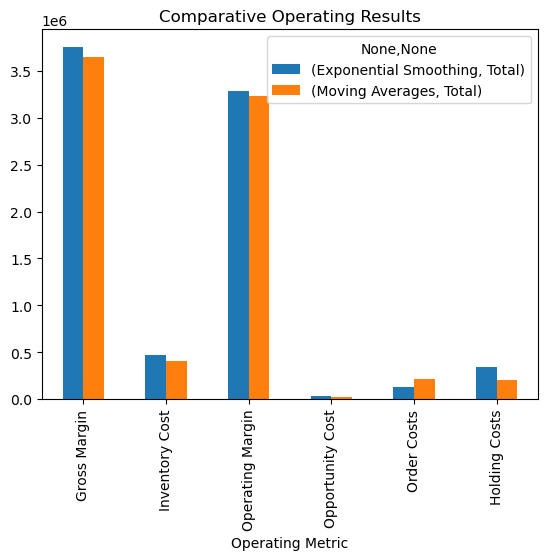

In [16]:
r = retail[sim_item]
c = cost[sim_item]
oc = order_cost[sim_item]
hc = holding_cost[sim_item]

es_analysis = operating_results(es_results, r, c, oc, hc)
ma_analysis = operating_results(ma_results, r, c, oc, hc)

print('Price Data:')
print(f"Product Margin: {r-c}")
print(f"Cost per Order: {oc}")
print(f"Holding Cost per Day: {hc}")

evaluate(es_analysis, ma_analysis)


### Analysis:

The more you run the simulation (see below), you will will quickly observe that exponential smoothing does not always increase the operating margin associated with the inventory strategy. However, in several cases it does. 

The distinction has to do with the specifications of the price data associated with the product.

When using exponential smoothing forecasting, the demand forecasts are more accurate. As a result, the inventory management strategy is better at having appropriate levels of inventory to meet demand. 

While this increases sales (the exponential smoothing methodology always has a higher gross margin), it also increases inventory holding costs. 

For items where the product margin is high in relation to holding costs, the extra sales are sufficient to cover the additional costs, and operating margin is increased by applying exponential smoothing. 

For items where the product margin is low in relation to holding costs, the extra sales <b> do not</b> cover the additional holding costs, and operating margin is decreased by applying exponential smoothing. 